# NLP Project - Sentiment Analysis

### Loading and Prep

Load, clean, and preprocess the data as you find necessary.

In [1]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from collections import Counter

df_train = pd.read_csv("sentiment_train.csv")

print(df_train.info())
print(df_train.head())

df_test = pd.read_csv("sentiment_test.csv")

print(df_test.info())
print(df_test.head())

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
None
                                            Sentence  Polarity
0                           Wow... Loved this place.         1
1                                 Crust is not good.         0
2          Not tasty and the texture was just nasty.         0
3  Stopped by during the late May bank holiday of...         1
4  The selection on the menu was great and so wer...         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB
No

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohammadananjaved/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohammadananjaved/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mohammadananjaved/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Feature Engineering

#### Count Special Characters

Writing functions to count the number of special characters. The idea is that negative sentiment reviews will have a lot of exclamation points, question marks & caps locks. This step is performed prior to preprocessing the data to remove punctuations. 

In [2]:
def count_specials(sentence):

    num_question_marks = 0
    num_exclamation_points = 0
    num_caps_lock = 0

    for char in sentence:
        if char == '?':
            num_question_marks += 1
        elif char == '!':
            num_exclamation_points += 1
        elif char.isupper():
            num_caps_lock += 1

    return num_question_marks + num_exclamation_points + num_caps_lock

In [3]:
def count_special_characters(data):
    data['special_character_count'] = [count_specials(sentence) for sentence in data['Sentence']]
    return data

#### Removing Stop Words with a Negative Sentiment

Some words which are classified as stop words are required to present the negative sentiment, such as, no, not, shouldn't, etc. Those words are deliberately removed from the list of stop words. This would ensure these words are present post stop word removal.

In [4]:
words_to_remove = ['no', 'not', "don't", "didn't", "didn'", "haven'", "haven't", "shouldn'", "shouldn't", "wasn'",
                  "wasn't", "weren'", "weren't"]

stop_words = [word for word in stop_words if word not in words_to_remove]

#### Text Pre Processing

In [5]:
def preprocess_text(text):

    # Tokenizing the text
    tokens = word_tokenize(text)
    
    # Removing punctuations from the text
    tokens = [token for token in tokens if token not in string.punctuation]
    
    #Removing numbers from the text
    tokens = [token for token in tokens if not token.isnumeric()]
    
    # Removing stopwords from the text and converting it to lowercase
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
        
    # Stemming the text
    tokens = [stemmer.stem(token) for token in tokens]
        
    return ' '.join(tokens)

In [6]:
def preprocessing_df(data):
    data['processed_text'] = data['Sentence'].apply(preprocess_text)
    return data

#### Word Count

Features are generated to get the total count of words in a sentence, the count of frequently occurring positive words, the count of frequently occurring negative words and the count of characters in sentences. 

In [7]:
processed_corpus_positive = [preprocess_text(doc) for doc in df_train[df_train['Polarity'] == 1]['Sentence']]
processed_corpus_negative = [preprocess_text(doc) for doc in df_train[df_train['Polarity'] == 0]['Sentence']]

all_words_positive = [word for doc in processed_corpus_positive for word in doc.split()]
all_words_negative = [word for doc in processed_corpus_negative for word in doc.split()]

word_counter_positive = Counter(all_words_positive)
word_counter_negative = Counter(all_words_negative)

num_words = 100
positive_popular_words = [word for word, freq in word_counter_positive.most_common(num_words)]
negative_popular_words = [word for word, freq in word_counter_negative.most_common(num_words)]

In [8]:
def count_words(sentence):
    words = sentence.split()
    return len(words)

def count_words_if_present(text, words_to_check):
    text_words = text.split()
    
    if any(word in text_words for word in words_to_check):
        return len(text_words)
    else:
        return 0

def length_of_review(data):
    data['word_count_in_review'] = [count_words(sentence) for sentence in data['Sentence']]
    data['character_count_in_review'] = [len(sentence) for sentence in data['Sentence']]
    data['frequent_positive_words'] = [count_words_if_present(word, positive_popular_words) for word in data['processed_text']]
    data['frequent_negative_words'] = [count_words_if_present(word, negative_popular_words) for word in data['processed_text']]

    return data

#### Frequency of Words 

Term Frequency - Inverse Document Frequency (TF-IDF) is applied on the 3000 most popular words in the corpus to indicate how popular / frequent they are in the dataset. The popular words are converted to vectors and the frequency of each word in the dataset is calculated. Focusing on the most popular words allows the dimensionality of the data to be reduced.

In [9]:
processed_corpus = [preprocess_text(doc) for doc in df_train['Sentence']]

all_words = [word for doc in processed_corpus for word in doc.split()]
word_counter = Counter(all_words)

num_popular_words = 3000
popular_words = [word for word, freq in word_counter.most_common(num_popular_words)]

In [10]:
def tfidf_vectorizer(data):

    from sklearn.feature_extraction.text import TfidfVectorizer
    
    tfidf = TfidfVectorizer(vocabulary = popular_words)
    X = tfidf.fit_transform(data)

    X_array = X.toarray()

    df = pd.DataFrame(X_array)
    df.columns = tfidf.get_feature_names_out()

    new_data = pd.concat([data, df], axis = 1)
    
    return new_data

def tfidf_vectorized_df(data):
    
    vectorized_df = tfidf_vectorizer(data['processed_text'])
    vectorized_df.drop(columns = ['processed_text'], inplace = True)
    data = vectorized_df.merge(data, how = 'inner', left_index = True, right_index = True)
    
    return data

Creating a pipeline function where all feature engineering functions are applied to the training data, to generate the feature columns, which would act as inputs to the classification model.

In [11]:
def pipeline(data, function_list):
    for function in function_list:
        data = function(data)
    return data

In [12]:
function_list = [count_special_characters,
                preprocessing_df,
                length_of_review,
                tfidf_vectorized_df
                ]

In [13]:
model_input = pipeline(df_train, function_list)

In [14]:
model_input.head()

,not,n't,good,great,phone,work,'s,food,place,servic,...,flag,subtl,Sentence,Polarity,special_character_count,processed_text,word_count_in_review,character_count_in_review,frequent_positive_words,frequent_negative_words
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.434918,0.0,...,0.0,0.0,Wow... Loved this place.,1,2,wow ... love place,4,24,4,4
1,0.357557,0.0,0.392351,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,Crust is not good.,0,1,crust not good,4,18,3,3
2,0.256631,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,Not tasty and the texture was just nasty.,0,1,not tasti textur nasti,8,41,4,4
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,Stopped by during the late May bank holiday of...,1,4,stop late may bank holiday rick steve recommen...,15,87,9,9
4,0.000000,0.0,0.000000,0.345649,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,The selection on the menu was great and so wer...,1,1,select menu great price,12,59,4,0


### Modeling - Logistic Regression

Use your favorite ML algorithm to train a classification model.  Don’t forget everything that we’ve learned in our ML course: hyperparameter tuning, cross validation, handling imbalanced data, etc. Make reasonable decisions and try to create the best-performing classifier that you can.

Logistic Regression is selected as the model of choice for this binary classification use case, given its ability to work with high dimensional data & sparse matrices.


In [15]:
X = model_input.drop(columns = ['Sentence', 'Polarity', 'processed_text'])
y = model_input['Polarity']
X.columns = X.columns.astype(str)

In [16]:
X.head()

,not,n't,good,great,phone,work,'s,food,place,servic,...,ceas,favourit,colour,flag,subtl,special_character_count,word_count_in_review,character_count_in_review,frequent_positive_words,frequent_negative_words
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.434918,0.0,...,0.0,0.0,0.0,0.0,0.0,2,4,24,4,4
1,0.357557,0.0,0.392351,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1,4,18,3,3
2,0.256631,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1,8,41,4,4
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,4,15,87,9,9
4,0.000000,0.0,0.000000,0.345649,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1,12,59,4,0


The training dataset is split into training & validation sets, to enable model evaluation during hyper parameter tuning.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3) 

#### Hyper Parameter Tuning : Optuna

The model is hyper parameter tuned using optuna. Optuna chooses the next value in the hyper parameter search space, depending on model performance in the previous run, allowing the search space to be scanned rather intentionally. The hyper parameter tuning is allowed to run for 1000 iterations, to get a good model fit.

Cross-validation is applied to ensure that the model does not overfit and memorize noise from the training data. The hyper parameter tuning is intended to optimize for macro F-1 score.

In [18]:
def objective(trial):
    
    C = trial.suggest_float('C', 1e-10, 1e10, log = True)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    l1_ratio = trial.suggest_float('l1_ratio', 1e-10, 1, log = True)
    
    classifier = LogisticRegression(C = C, 
                                    solver = solver, 
                                    max_iter = 5000, 
                                    l1_ratio = l1_ratio,
                                   )
    
    ## F-1 macro is the used as the scoring variable - so that an adequate accuracy can be obtained for both 
    ## positive & negative classes
    
    scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring = 'f1_macro')
    mean_score = scores.mean()
    
    return mean_score

In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials=1000)  

print(f'Number of finished trials: {len(study.trials)}')
print(f'Best trial:')
trial = study.best_trial

print(f'  Value (macro F1 score): {-trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

The best set of hyper parameter values, post hyper parameter tuning

In [31]:
lr_model = LogisticRegression(
    C = 1.8146379180758552,
    solver = 'lbfgs',
    l1_ratio = 0.0003371579751677212,
    max_iter = 5000
)

lr_model.fit(X_train, y_train)

/Users/mohammadananjaved/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


LogisticRegression(C=1.8146379180758552, l1_ratio=0.0003371579751677212,
                   max_iter=5000)

In [32]:
print(classification_report(y_train, lr_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       857
           1       0.96      0.93      0.95       823

    accuracy                           0.95      1680
   macro avg       0.95      0.95      0.95      1680
weighted avg       0.95      0.95      0.95      1680



### Threshold Tuning

Threshold tuning was performed to account for the imbalance in positive / negative class distributions, and to make the model more receptive 

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

thresholds = [i/100 for i in range(100)]

y_prob = lr_model.predict_proba(X_train)[:,1]

for thresh in thresholds:
    y_pred = [1 if p > thresh else 0 for p in y_prob]
    
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

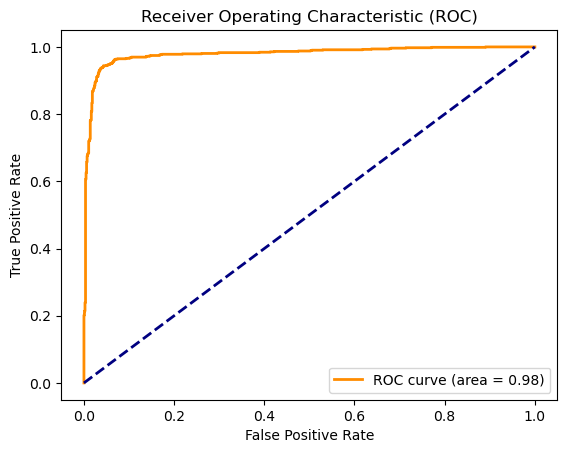

Optimal Threshold: 0.4724771121881405


In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_train, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
test_prediction_prob = lr_model.predict_proba(X_train)[:,1]

test_predictions = [1 if p >  optimal_threshold else 0 for p in test_prediction_prob]
print("Optimal Threshold:", optimal_threshold)

In [23]:
val_prediction_prob = lr_model.predict_proba(X_val)[:,1]

val_predictions = [1 if p > optimal_threshold else 0 for p in val_prediction_prob]

print(classification_report(y_val, val_predictions))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81       356
           1       0.81      0.84      0.82       364

    accuracy                           0.82       720
   macro avg       0.82      0.82      0.82       720
weighted avg       0.82      0.82      0.82       720



**Training Performance:** The classification report indicates a good model of the binary classifier, Logisitic Regression model on the underlying training data, indicated by the high macro F-1 score. The precision and recall are also high for both positive & negative classes, implying the model is good at predicting both classes in the training dataset.

**Validation Performance:** The classification report on the validation set shows slightly lower values than the training set, which is expected. The drop is not too drastic, implying the model does not overfit on the training data and has not memorized noise from it. The model is rather **generalized** in classifying sentiment with an adequate accuracy. 

### Assessing

Use the testing data to measure the accuracy and F1-score of your model.  

In [35]:
## The pipeline created is applied to the testing data to make it ready for obtaining model predictions from

model_input_test = pipeline(df_test, function_list)

In [36]:
X_test = model_input_test.drop(columns = ['Sentence', 'Polarity', 'processed_text'])
y_test = model_input_test['Polarity']
X_test.columns = X_test.columns.astype(str)
test_prediction_prob = lr_model.predict_proba(X_test)[:,1]

test_predictions = [1 if p > optimal_threshold else 0 for p in test_prediction_prob]

In [37]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77       287
           1       0.83      0.67      0.74       313

    accuracy                           0.76       600
   macro avg       0.77      0.76      0.76       600
weighted avg       0.77      0.76      0.76       600



### Assessment of Model Performance

**Assessing Model Fit**

The classification model developed is a binary classifier, which predicts positive sentiment as the positive class (1) and negative sentiment as the negative class (0). The model is **generalized** in classifying positive / negative sentiment with an adequate accuracy, and does not overfit on the training data. 

**Performance on Testing Data**

The macro F-1 score and accuracy score are both 76%. The macro precision of the model is 77%, whereas the macro recall is 76%, implying that the model is able to correctly predict positive / negative sentiments 77 out of 100 times and 76% of all use cases are correctly captured by the model.

If we look at the results of the individual positive and negative classes, we notice the positive class (which demonstrate positive sentiment) has a precision of 83% and a recall of 67%. The recall of 67% implies there are a lot of missed opportunities in predicting which statements demonstrate positive sentiment - only 67% of all positive sentiment use cases are correctly predicted for. 

The negative class (which demonstrates negative sentiment in this case) has a higher recall of 85%, but a slightly lower precision of 70%. This means 84% of all negative sentiment use cases are correctly predicted for, with the predictions being accurate 70 out of 100 times. 

**Summary**: The model is incorrectly classifying many positive sentiments as negative!

The model is casting a wider net and correctly capturing more of the negative class than the positive class. The usefulness of the model would depend on the business use case it is used for - if the use case happens to be identifying negative sentiment, such as, detecting adverse drug reactions based on social media mentions, the model will capture most of the negative comments, with fewer missed opportunities. If the use case happens to be identifying positive sentiment, such as, a business owner looking to thank customers for positive online reviews, there will be a lot of missed opportunities. 

**Next Steps**: As explained in more detail in part 3, the model is not looking at some of the words in context and there seems to be an over-reliance on the bag-of-words. Some sentences have sarcasm, nuances, complex sentence structures and words often have double meanings. Using a pre-trained NLP API, such as, Google's BERT or OpenAI's GPT, will allow words to be understood in context.

### Use Cases to Assess Model Predictions

In [27]:
test_results = (pd.DataFrame(test_predictions).merge(df_test[['Sentence', 'Polarity']], left_index = True, right_index = True)).merge(X_test,
                                                                                                           left_index = True,
                                                                                                           right_index = True,
                                                                                                           how = 'inner')

In [28]:
test_results.rename(columns = {0:'Test_Prediction'}, inplace = True)

In [29]:
test_results[(test_results['Test_Prediction'] == 0) & (test_results['Polarity'] == 1)].head(5)

,Test_Prediction,Sentence,Polarity,not,n't,good,great,phone,work,'s,...,ceas,favourit,colour,flag,subtl,special_character_count,word_count_in_review,character_count_in_review,frequent_positive_words,frequent_negative_words
12,0,Not too screamy not to masculine but just righ...,1,0.643795,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,9,50,5,5
14,0,I would have casted her in that role after rea...,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,12,62,5,5
36,0,"The soundtrack wasn't terrible, either.",1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,5,41,4,4
38,0,"Still, it was the SETS that got a big ""10"" on ...",1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5,14,66,10,10
43,0,The last 15 minutes of movie are also not bad ...,1,0.308524,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,12,56,7,7


#### Examples of instances where model predictions were incorrect:

**False Negatives**

* Not too screamy not to masculine but just right.
* I would have casted her in that role after ready the script.
* The soundtrack wasn't terrible, either.
* Still, it was the SETS that got a big "10" on my "oy-vey" scale.
* The last 15 minutes of movie are also not bad as well.

In some of the instances above, we notice "double negatives" - **"wasn't terrible", "still", "not too screamy not to ..", "not bad".** The double negative is meant to mean something positive, which wasn't properly captured by the classification model. 

The presence of strong negative sentiment words, such as, "not", "terrible", "garbage" - caused these reviews to be incorrectly classified as negative sentiment. There are features to capture the count of highly indexing positive sentiment words & negative sentiment words. 

There is some sarcasm and nuance in some of the comments, leading to a complex sentence construct, which wasn't properly captured by the algorithm. 

**The last 15 minutes of movie are also not bad as well.** - This has the words "not bad" to negate each other, indicating the ending of the movie was good. This sentence has 2 negative sentiment words - "not", "bad", causing this to be incorrectly classed as negative.

In [30]:
test_results[(test_results['Test_Prediction'] == 1) & (test_results['Polarity'] == 0)].tail(5)

,Test_Prediction,Sentence,Polarity,not,n't,good,great,phone,work,'s,...,ceas,favourit,colour,flag,subtl,special_character_count,word_count_in_review,character_count_in_review,frequent_positive_words,frequent_negative_words
502,1,"As for the killer, don't expect anything origi...",0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,12,81,8,8
504,1,I'm so sorry but I really can't recommend it t...,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,11,57,7,7
510,1,I highly doubt that anyone could ever like thi...,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,10,56,7,7
519,1,"Characters are one-dimensional, even the good ...",0,0.0,0.0,0.239244,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,12,81,8,8
553,1,"Just whatever you do, avoid ""Groove"" as its th...",0,0.0,0.0,0.377720,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4,18,101,9,9


**False Positives**

* As for the killer, don't expect anything original or even remotely frightening.
* I'm so sorry but I really can't recommend it to anyone.	
* I highly doubt that anyone could ever like this trash.
* Characters are one-dimensional, even the good guys and especially the bad guys.
* Just whatever you do, avoid "Groove" as its the antithesis of all that is good about Human Traffic.

The sentences which are incorrectly classified as positive sentiment contain strong positive sentiment words, such as, "original", "good", "like", etc. 

Some sentences have apologies or sarcasm, which are complex sentence structures, which are not properly captured by the model. Sentences have nuances, such as, "or even remotely", which seem to be interpreted by the model quite literally and not in context, leading to an incorrect sentiment prediction. There seems to be an over-reliance on the bag of words and the frequency of words (tf-idf), causing some words / phrases to be taken quite literally and not in context. 

**"I'm so sorry but I really can't recommend it to anyone"** - the word "sorry" appears to be a negative sentiment word, but in this case, the sorry is used to refer to an apology. It must also be noted that certain words can have double meanings and not reading the sentence in context, can cause the model to incorrectly classify its sentiment.
